In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from IPython import display
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
     

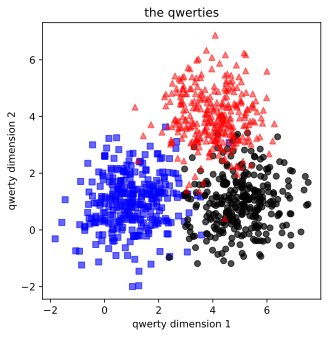

In [26]:
nPerClust=300
blur=1

A=[1,1]
B=[5,1]
C=[4,4]
a=[A[0]+np.random.randn(nPerClust)*blur,A[1]+np.random.randn(nPerClust)*blur ]
b=[B[0]+np.random.randn(nPerClust)*blur,B[1]+np.random.randn(nPerClust)*blur ]
c=[C[0]+np.random.randn(nPerClust)*blur,C[1]+np.random.randn(nPerClust)*blur ]

labels_np=np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1)), 1+np.ones((nPerClust,1))))
data_np=np.hstack((a,b,c)).T
data=torch.tensor(data_np).float()
labels=torch.squeeze(torch.tensor(labels_np).long())
fig=plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1],'bs',alpha=0.6)
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1],'ko',alpha=.7)
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1],'r^',alpha=0.5)

plt.title("the qwerties")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
data, labels, test_size=0.3, random_state=42)
train_data=TensorDataset(X_train,y_train)
test_data=TensorDataset(X_test,y_test)
batchsize=16
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])




In [6]:
 print(f'there are {len(train_loader)} batches, each with {batchsize} samples.')

there are 39 batches, each with 16 samples.


In [9]:
def createTheQwertyNet():
    class qwertynet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input=nn.Linear(2,8)
            self.fc1=nn.Linear(8,8)
            self.output=nn.Linear(8,3)
            
        def forward(self,x):
            x=F.relu(self.input(x))
            x=F.relu(self.fc1(x))
            return self.output(x)
        
    net=qwertynet()
    lossfun=nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(net.parameters(),lr=0.01)
    return net,lossfun,optimizer
        

In [10]:
net,lossf,opt=createTheQwertyNet()
print(net)


qwertynet(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


In [11]:
net(torch.randn(10,2))

tensor([[ 0.4652, -0.3668,  0.4129],
        [ 0.5362, -0.4297,  0.5048],
        [ 0.5112, -0.4118,  0.4823],
        [ 0.5775, -0.4480,  0.5415],
        [ 0.4975, -0.3959,  0.4696],
        [ 0.5272, -0.4162,  0.4963],
        [ 0.4536, -0.3578,  0.3937],
        [ 0.4736, -0.3738,  0.4287],
        [ 0.5169, -0.4042,  0.4868],
        [ 0.5216, -0.4179,  0.4915]], grad_fn=<AddmmBackward0>)

In [12]:
def trainModel():
    numepochs=1000
    net,lossfun,optimizer=createTheQwertyNet()
    losses=torch.zeros(numepochs)
    trainAcc=[]
    testAcc=[]
    for epochi in range(numepochs):
        net.train()
        batchAcc=[]
        batchLoss=[]
        for X,y in train_loader:
            yHat=net(X)
            loss=lossfun(yHat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batchLoss.append(loss.item())
            matches=(torch.argmax(yHat,axis=1)==y).float()
            accuracy=100*torch.mean(matches)
            
            batchAcc.append(accuracy)
        trainAcc.append(np.mean(batchAcc))
        losses[epochi]=np.mean(batchLoss)
        net.eval()
        X,y=next(iter(test_loader))
        with torch.no_grad():
            yHat=net(X)
        matches=(torch.argmax(yHat,axis=1)==y).float()
        accuracy=100*torch.mean(matches)
        
            
        testAcc.append(accuracy)
    return trainAcc,testAcc,losses,net


In [13]:
trainAcc,testAcc,losses,net=trainModel()


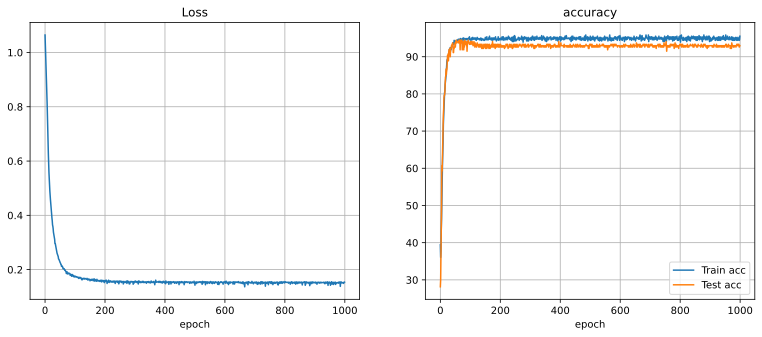

In [15]:
fig,ax=plt.subplots(1,2,figsize=(13,5))
ax[0].plot(losses)
ax[0].set_title('Loss')
ax[1].plot(trainAcc)
ax[1].plot(testAcc)
ax[1].set_title('accuracy')
ax[1].legend(['Train acc','Test acc'])
for i in range(2):
    
    ax[i].set_xlabel('epoch')
    ax[i].grid()
#     with zscore
    

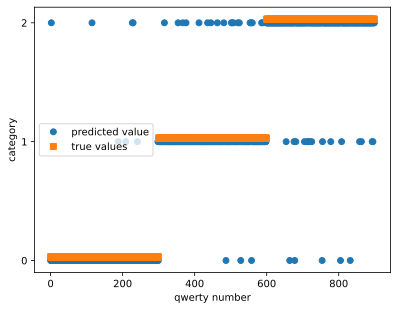

In [19]:
yHat=net(data)
predictions=torch.argmax(yHat,axis=1)
plt.plot(predictions,'o',label='predicted value')
plt.plot(labels+0.03,'s',label='true values')
plt.xlabel('qwerty number')
plt.ylabel('category')
plt.yticks([0,1,2])
plt.legend()
plt.show()

(80.0, 100.0)

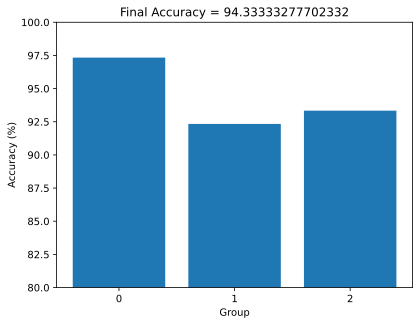

In [24]:
matches=(predictions==labels).float()
totalAcc=100*torch.mean(matches).item()
accuracyByGroup=np.zeros(3)
for i in range(3):
    accuracyByGroup[i]=100*torch.mean(matches[labels==i])
    
plt.bar(range(3),accuracyByGroup)
plt.xticks([0,1,2])
plt.title(f'Final Accuracy = {totalAcc}')
plt.ylabel('Accuracy (%)')
plt.xlabel('Group')
plt.ylim([80,100])


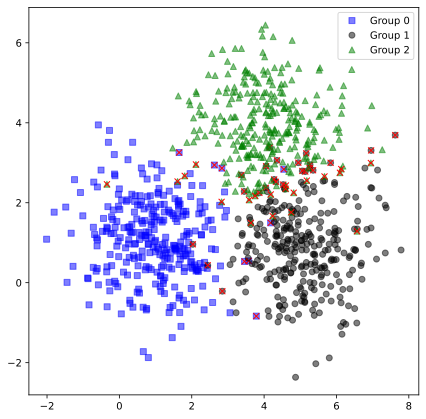

In [34]:
colorshapes=['bs','ko','g^']
fig=plt.figure(figsize=(7,7))
for i in range(3):
    plt.plot(data[labels==i,0],data[labels==i,1],colorshapes[i],alpha=0.5,
            label=f'Group {i}')
    idxError=(matches==0)&(labels==i)
    plt.plot(data[idxError,0],data[idxError,1],'rx')
plt.legend()

In [35]:
def createTheQwertyNet(momentum):
    class qwertynet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input=nn.Linear(2,8)
            self.fc1=nn.Linear(8,8)
            self.output=nn.Linear(8,3)
            
        def forward(self,x):
            x=F.relu(self.input(x))
            x=F.relu(self.fc1(x))
            return self.output(x)
        
    net=qwertynet()
    lossfun=nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(net.parameters(),lr=0.01,momentum=momentum)
    return net,lossfun,optimizer
        

In [36]:
net,lossf,opt=createTheQwertyNet(0.9)
print(opt)


SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [40]:
def trainModel(momentum):
    numepochs=1000
    net,lossfun,optimizer=createTheQwertyNet(momentum=momentum)
    losses=torch.zeros(numepochs)
    trainAcc=[]
    testAcc=[]
    for epochi in range(numepochs):
        net.train()
        batchAcc=[]
        batchLoss=[]
        for X,y in train_loader:
            yHat=net(X)
            loss=lossfun(yHat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batchLoss.append(loss.item())
            matches=(torch.argmax(yHat,axis=1)==y).float()
            accuracy=100*torch.mean(matches)
            
            batchAcc.append(accuracy)
        trainAcc.append(np.mean(batchAcc))
        losses[epochi]=np.mean(batchLoss)
        net.eval()
        X,y=next(iter(test_loader))
        with torch.no_grad():
            yHat=net(X)
        matches=(torch.argmax(yHat,axis=1)==y).float()
        accuracy=100*torch.mean(matches)
        
            
        testAcc.append(accuracy)
    return trainAcc,testAcc,losses,net
 

In [41]:
momenta=[0,0.5,0.9,0.95,0.99]
results=np.zeros((1000,len(momenta),3))
for idx,mom in enumerate(momenta):
    trainAcc,testAcc,losses,net=trainModel(mom)
    results[:,idx,0]=losses
    results[:,idx,1]=trainAcc
    results[:,idx,2]=testAcc
    

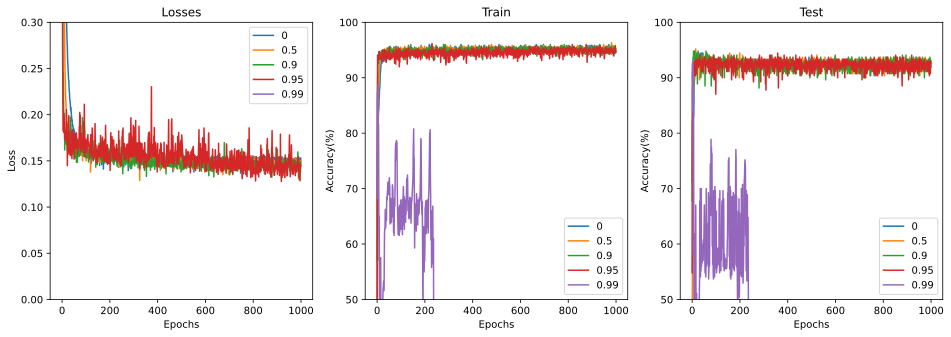

In [46]:
fig,ax=plt.subplots(1,3,figsize=(16,5))
for i in range(3):
    ax[i].plot(results[:,:,i])
    ax[i].legend(momenta)
    ax[i].set_xlabel('Epochs')
    if i==0:
        ax[i].set_ylabel('Loss')
        ax[i].set_ylim([0,0.3])
    else:
        ax[i].set_ylabel('Accuracy(%)')
        ax[i].set_ylim([50,100])
ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')
plt.show()

In [7]:
def createTheQwertyNet(optimizerAlgo):
    class qwertynet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input=nn.Linear(2,8)
            self.fc1=nn.Linear(8,8)
            self.output=nn.Linear(8,3)
            
        def forward(self,x):
            x=F.relu(self.input(x))
            x=F.relu(self.fc1(x))
            return self.output(x)
        
    net=qwertynet()
    lossfun=nn.CrossEntropyLoss()
    optifun=getattr(torch.optim,optimizerAlgo)
    optimizer=optifun(net.parameters(),lr=0.01)
    return net,lossfun,optimizer
        

In [9]:
optim=createTheQwertyNet('RMSprop')[2]
optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

In [10]:
def trainModel(optimizerType):
    numepochs=1000
    net,lossfun,optimizer=createTheQwertyNet(optimizerType)
    losses=torch.zeros(numepochs)
    trainAcc=[]
    testAcc=[]
    for epochi in range(numepochs):
        net.train()
        batchAcc=[]
        batchLoss=[]
        for X,y in train_loader:
            yHat=net(X)
            loss=lossfun(yHat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batchLoss.append(loss.item())
            matches=(torch.argmax(yHat,axis=1)==y).float()
            accuracy=100*torch.mean(matches)
            
            batchAcc.append(accuracy)
        trainAcc.append(np.mean(batchAcc))
        losses[epochi]=np.mean(batchLoss)
        net.eval()
        X,y=next(iter(test_loader)) 
        with torch.no_grad():
            yHat=net(X)
        matches=(torch.argmax(yHat,axis=1)==y).float()
        accuracy=100*torch.mean(matches)
        
            
        testAcc.append(accuracy)
    return trainAcc,testAcc,losses,net


In [14]:
def plotTheResults(optimizerType):
    yHat=net(data)
    predictions=torch.argmax(yHat,axis=1)
    accuracy=(predictions==labels).float()
    totalAcc=torch.mean(100*accuracy).item()
    accuracyByGroup=np.zeros(3)
    for i in range(3):
        accuracyByGroup[i]=100*torch.mean(accuracy[labels==i])
    fig,ax=plt.subplots(2,2,figsize=(12,8))
    ax[0,0].plot(losses.detach())
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_xlabel('Epoch')
    ax[0,0].set_title(f'{optimizerType}: Losses')
    ax[0,1].plot(trainAcc,label='Train')
    ax[0,1].plot(testAcc,label='Test')
    
    ax[0,1].set_ylabel('Accuracy(%)')
    ax[0,1].set_xlabel('Epoch')
    ax[0,1].set_title(f'{optimizerType}: Accuracy')
    ax[0,1].legend()
    ax[1,0].bar(range(3),accuracyByGroup)
    ax[1,0].set_ylabel('Accuracy(%)')
    ax[1,0].set_xticks([0,1,2])
    ax[1,0].set_xlabel('Group')
    ax[1,0].set_title(f'{optimizerType}: test Acc')
    colorshapes=['bs','ko','g^']

    for i in range(3):
        ax[1,1].plot(data[labels==i,0],data[labels==i,1],colorshapes[i],alpha=0.5,
            label=f'Group {i}')
    idxError=(accuracy==0)&(labels==i)
    ax[1,1].plot(data[idxError,0],data[idxError,1],'rx')
    ax[1,1].legend()
    ax[1,1].set_title(f'{optimizerType}:Total Accuracy : {totalAcc:.3f}%')
    ax[1,1].set_xlabel('qwerty dimension1')
    ax[1,1].set_ylabel('qwerty dimension2')
    plt.tight_layout()
    plt.show()

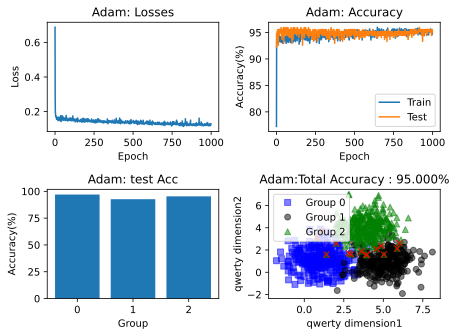

In [13]:
trainAcc,testAcc,losses,net=trainModel('Adam')

plotTheResults('Adam')

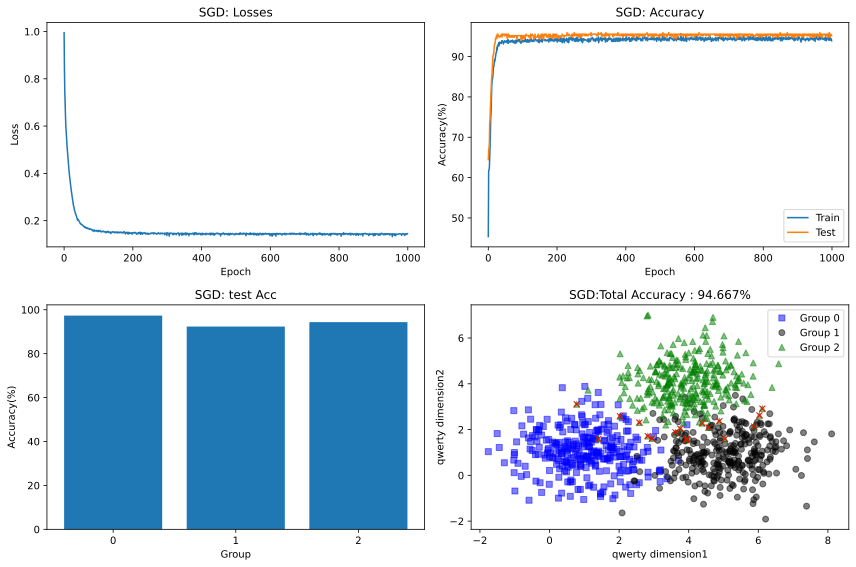

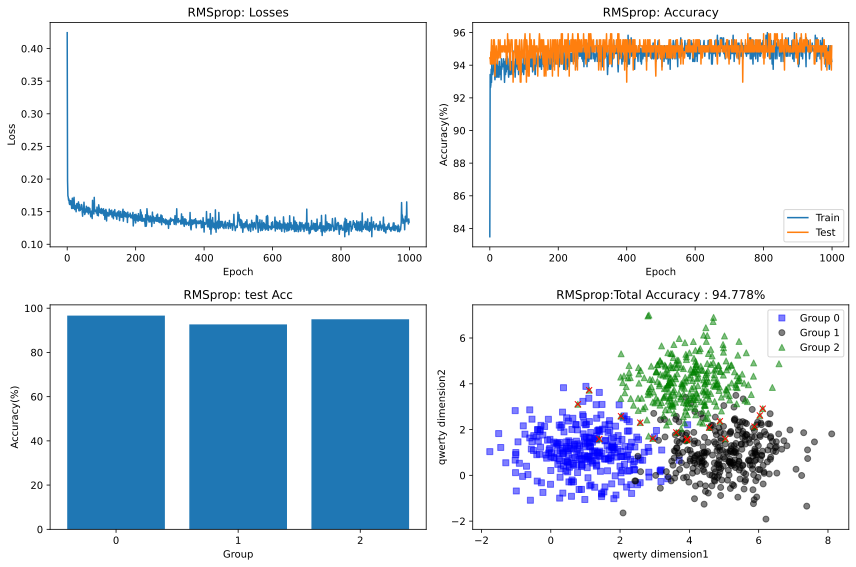

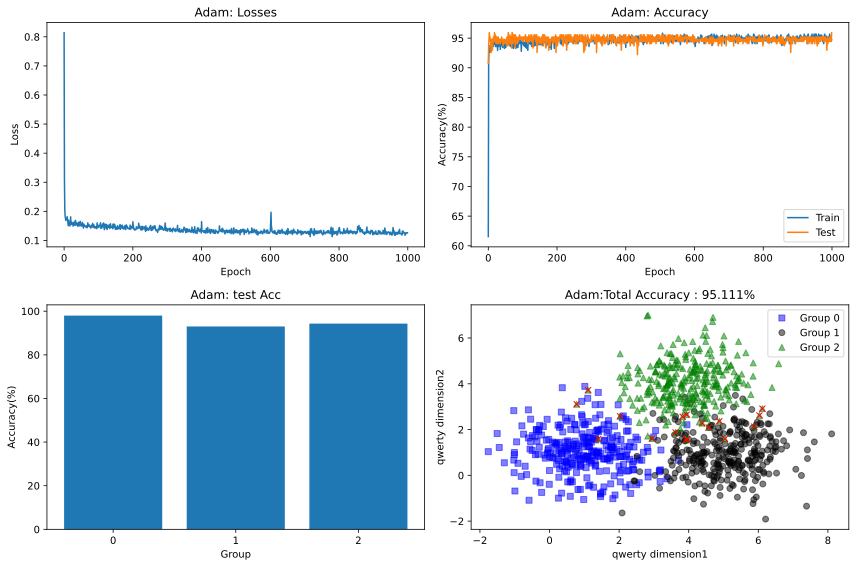

['SGD: train 94.295% , test 95.222%',
 'RMSprop: train 94.471% , test 94.519%',
 'Adam: train 95.000% , test 94.815%']

In [15]:
performance=[]
for opto in ['SGD','RMSprop','Adam']:
    trainAcc,testAcc,losses,net=trainModel(opto)
    plotTheResults(opto)
    train=np.mean(trainAcc[-10:])
    test=np.mean(testAcc[-10:])
    performance.append(f'{opto}: train {train:.3f}% , test {test:.3f}%')
performance

In [4]:
def createTheQwertyNet(optimizerAlgo,learningRate):
    class qwertynet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input=nn.Linear(2,8)
            self.fc1=nn.Linear(8,8)
            self.output=nn.Linear(8,3)
            
        def forward(self,x):
            x=F.relu(self.input(x))
            x=F.relu(self.fc1(x))
            return self.output(x)
        
    net=qwertynet()
    lossfun=nn.CrossEntropyLoss()
    optifun=getattr(torch.optim,optimizerAlgo)
    optimizer=optifun(net.parameters(),lr=learningRate)
    return net,lossfun,optimizer
        

In [5]:
def trainModel(optimizerType,lr):
    numepochs=100
    net,lossfun,optimizer=createTheQwertyNet(optimizerType,lr)
    losses=torch.zeros(numepochs)
    trainAcc=[]
    testAcc=[]
    for epochi in range(numepochs):
        net.train()
        batchAcc=[]
        batchLoss=[]
        for X,y in train_loader:
            yHat=net(X)
            loss=lossfun(yHat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batchLoss.append(loss.item())
            matches=(torch.argmax(yHat,axis=1)==y).float()
            accuracy=100*torch.mean(matches)
            
            batchAcc.append(accuracy)
        trainAcc.append(np.mean(batchAcc))
        losses[epochi]=np.mean(batchLoss)
        net.eval()
        X,y=next(iter(test_loader)) 
        with torch.no_grad():
            yHat=net(X)
        matches=(torch.argmax(yHat,axis=1)==y).float()
        accuracy=100*torch.mean(matches)
        
            
        testAcc.append(accuracy)
    return trainAcc,testAcc,losses,net


In [6]:
performance=np.zeros((3,20))
for i,opto in enumerate(['SGD','RMSprop','Adam']):
    for j,lr in enumerate(np.logspace(-4,-1,20)):
        trainAcc,testAcc,losses,net=trainModel(opto,lr)
        test=np.mean(testAcc[-10:])
        performance[i,j]=test
        

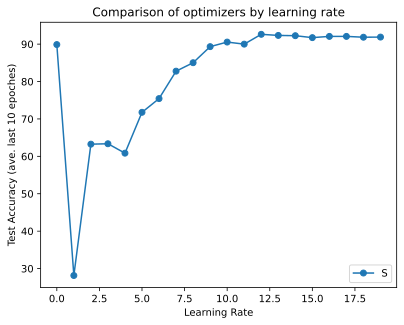

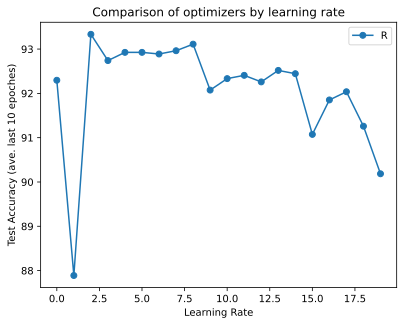

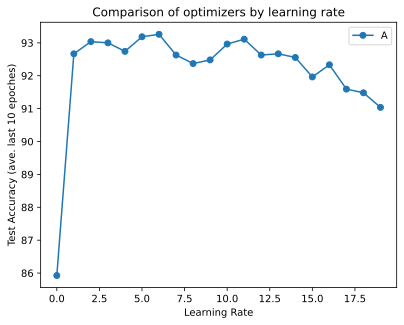

In [25]:
ls=['SGD','RMSprop','Adam']
for i in range(3):
    
    plt.plot(performance[i,:],'o-')
    plt.legend(ls[i])
    plt.xlabel('Learning Rate')
    plt.ylabel('Test Accuracy (ave. last 10 epoches)')
    plt.title('Comparison of optimizers by learning rate')
    plt.show()

In [28]:
def createTheQwertyNet(initialLR):
    class qwertynet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input=nn.Linear(2,8)
            self.fc1=nn.Linear(8,8)
            self.output=nn.Linear(8,3)
            
        def forward(self,x):
            x=F.relu(self.input(x))
            x=F.relu(self.fc1(x))
            return self.output(x)
        
    net=qwertynet()
    lossfun=nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(net.parameters(),lr=initialLR)
    stepsize=batchsize*len(train_loader)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer,
                                              step_size=stepsize,gamma=0.5)
    return net,lossfun,optimizer,scheduler
        

In [31]:
def trainModel(initialLR,toggleDynamicLR):
    numepochs=100
    net,lossfun,optimizer,scheduler=createTheQwertyNet(initialLR)
    losses=torch.zeros(numepochs)
    trainAcc=[]
    testAcc=[]
    currentLR=[]
    for epochi in range(numepochs):
        net.train()
        batchAcc=[]
        batchLoss=[]
        for X,y in train_loader:
            yHat=net(X)
            loss=lossfun(yHat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if toggleDynamicLR:
                scheduler.step()
                
            batchLoss.append(loss.item())
            matches=(torch.argmax(yHat,axis=1)==y).float()
            accuracy=100*torch.mean(matches)
            
            batchAcc.append(accuracy)
            currentLR.append(scheduler.get_last_lr()[0])
        trainAcc.append(np.mean(batchAcc))
        losses[epochi]=np.mean(batchLoss)
        net.eval()
        X,y=next(iter(test_loader)) 
        with torch.no_grad():
            yHat=net(X)
        matches=(torch.argmax(yHat,axis=1)==y).float()
        accuracy=100*torch.mean(matches)
        
            
        testAcc.append(accuracy)
    return trainAcc,testAcc,losses,net,currentLR



Text(0.5, 1.0, 'Learning rate shouldn change')

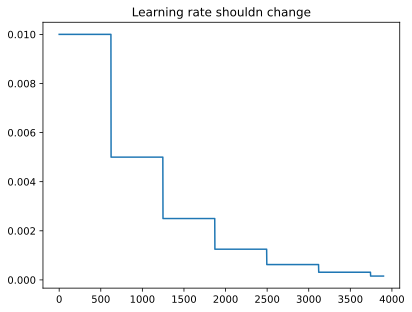

In [32]:
trainAcc,testAcc,losses,net,currentLR=trainModel(0.01,True)
plt.plot(currentLR)
plt.title('Learning rate should change')

Text(0.5, 1.0, 'Learning rate should stay fixed')

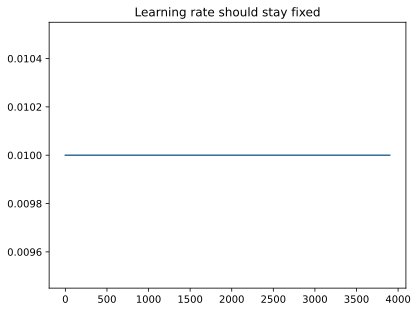

In [33]:
trainAcc,testAcc,losses,net,currentLR=trainModel(0.01,False)
plt.plot(currentLR)
plt.title('Learning rate should stay fixed')

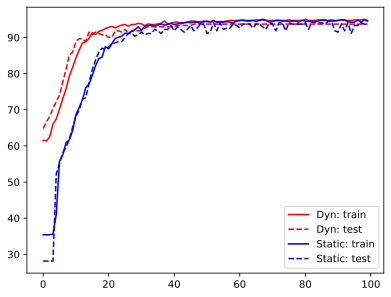

In [35]:
trainAccDyn,testAccDyn,lossesDyn,net,currentLR=trainModel(0.01,True)
trainAccSta,testAccSta,lossesSta,net,currentLR=trainModel(0.01,False)
plt.plot(trainAccDyn,'r',label='Dyn: train')
plt.plot(testAccDyn,'r--',label='Dyn: test')
plt.plot(trainAccSta,'b',label='Static: train')
plt.plot(testAccSta,'b--',label='Static: test')
plt.legend()